In [14]:
import os
import gc
import pandas as pd
pd.set_option('display.max_colwidth', 100)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
import string
from nltk.corpus import words
from nltk.tokenize import word_tokenize
import mlflow
import mlflow.sklearn
import mlflow.keras
import sklearn.metrics
from mlflow.models.signature import infer_signature
from sklearn.model_selection import GridSearchCV
import re
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import auc as auc_score_func
from sklearn.metrics import make_scorer, classification_report, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import spacy
from spacy.tokens import Doc
from spacy.language import Language
import gensim
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Embedding, LSTM, Dense, Dropout, Flatten, Input, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from keras.callbacks import EarlyStopping
from transformers import BertTokenizer, TFBertModel
from tqdm import tqdm
from gensim.models import Word2Vec
from gensim.test.utils import common_texts
from gensim.models import KeyedVectors
import gensim.downloader as api
import fasttext.util

In [2]:
print(tf.config.get_visible_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
def load_data():
    column_names = ["target", "ids", "date", "flag", "user", "text"]
    df = pd.read_csv("sentiment140/training.1600000.processed.noemoticon.csv", names=column_names, encoding='latin1')
    display(df)
    return df

df = load_data()

## Analyse des données

In [4]:
df.info()
df.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


target          2
ids       1598315
date       774363
flag            1
user       659775
text      1581466
dtype: int64

target    0.0
ids       0.0
date      0.0
flag      0.0
user      0.0
text      0.0
dtype: float64
Nombres de tweets dupliqués :  18534
col = target -> duplicated = 1599998
col = ids -> duplicated = 1685
col = date -> duplicated = 825637
col = flag -> duplicated = 1599999
col = user -> duplicated = 940225
col = text -> duplicated = 18534


0          False
1          False
2          False
3          False
4          False
           ...  
1599995    False
1599996    False
1599997    False
1599998    False
1599999    False
Name: text, Length: 1600000, dtype: bool


,target,ids
count,1.600000e+06,1.600000e+06
mean,2.000000e+00,1.998818e+09
std,2.000001e+00,1.935761e+08
min,0.000000e+00,1.467810e+09
25%,0.000000e+00,1.956916e+09
50%,2.000000e+00,2.002102e+09
75%,4.000000e+00,2.177059e+09
max,4.000000e+00,2.329206e+09


,date,flag,user,text
count,1600000,1600000,1600000,1600000
unique,774363,1,659775,1581466
top,Mon Jun 15 12:53:14 PDT 2009,NO_QUERY,lost_dog,isPlayer Has Died! Sorry
freq,20,1600000,549,210


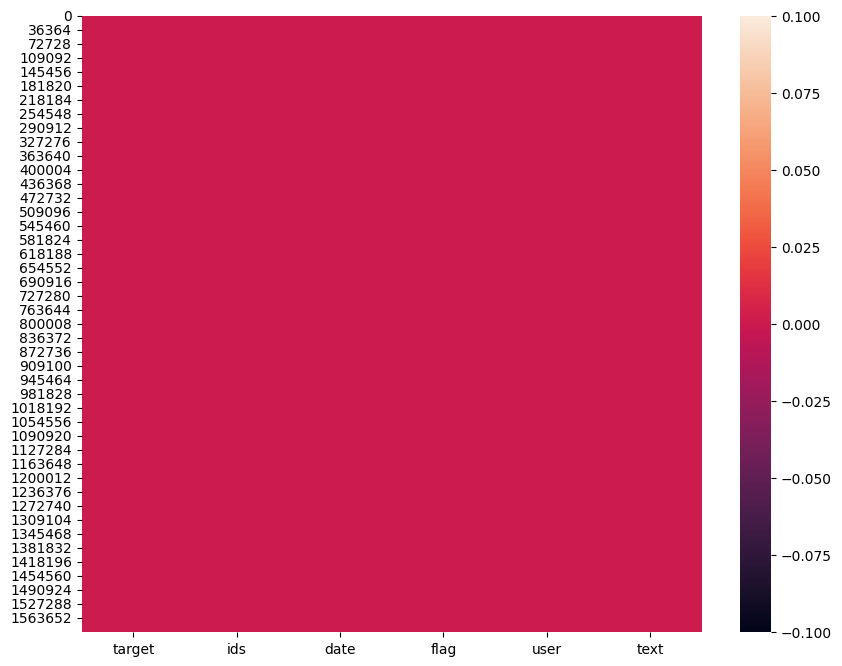

In [5]:
def analyse_data(data):
    """
    Analyse un DataFrame en affichant le pourcentage de valeurs manquantes, une heatmap des valeurs manquantes,
    le nombre de doublons pour l'ensemble du DataFrame et par colonne. Affiche également des statistiques
    descriptives pour les colonnes numériques et non numériques.

    Args:
        data (pandas.DataFrame): DataFrame à analyser.

    Returns:
        None. Cette fonction affiche directement les informations et les graphiques.
    """
    print(data.isna().mean().sort_values())
    plt.figure(figsize=(10, 8))
    sns.heatmap(data.isna())
    print("Nombres de tweets dupliqués : ", data.text.duplicated().sum())
    for col in data.columns:
        n = data[col].duplicated().sum()
        print(f"col = {col} -> duplicated = {n}")
    print("\n")
    print(data.text.duplicated(keep="first"))
    idx = data.text.duplicated(keep="first")
    data.loc[idx, :].sort_values("text").head(10)
    display(data.describe(include=np.number))
    display(data.describe(include=object))

analyse_data(df)

Text(0.5, 1.0, 'Distribution du nombre de caractères des tweets')

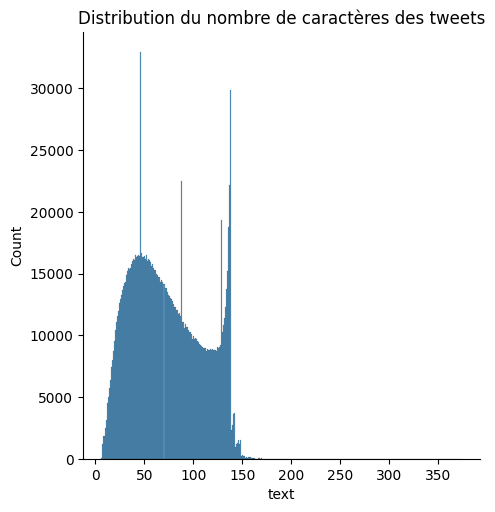

In [6]:
tmp = df.text.str.len()
sns.displot(tmp)
plt.title("Distribution du nombre de caractères des tweets")

In [7]:
tmp.sort_values(ascending=False)

1295281    374
1484882    369
380539     359
1582941    359
650945     348
          ... 
1071086      6
1229947      6
4233         6
310554       6
1050599      6
Name: text, Length: 1600000, dtype: int64

In [ ]:
def drop_columns(df):
    df = df[['target', 'text']]
    return df

def drop_text_duplicate(df):
    df = df.drop_duplicates(subset="text")
    return df

def filter_tweet(df):
    df['text'] = df['text'].str.strip()
    filtered_df = df[df['text'].str.match('^(@\w+\s*)+$')]
    df = df.drop(filtered_df.index, axis= 0)
    display(filtered_df.head(20))
    print(f"Nombre de tweets non informatif supprimés : {filtered_df.shape[0]}")
    return df

df = drop_columns(df)
df = drop_text_duplicate(df)
df = filter_tweet(df)

In [5]:
def create_sample(df, n_sample):
    negative_tweets = df[df.iloc[:, 0] == 0]
    negative_tweets = negative_tweets.sample(n = n_sample, random_state=0)
    positive_tweets = df[df.iloc[:, 0] == 4]
    positive_tweets.loc[:,'target'] = positive_tweets['target'].replace({4:1})
    positive_tweets = positive_tweets.sample(n = n_sample, random_state=0)
    df_sample = pd.concat([negative_tweets, positive_tweets], ignore_index=True)
    return df_sample
df_sample = create_sample(df, 300_000)

NameError: name 'df' is not defined

In [10]:
df_sample.target.value_counts(normalize=True)

target
0    0.5
1    0.5
Name: proportion, dtype: float64

In [ ]:
def display_tokens_info(tokens):
    """display info about corpus"""
    print(f"nb tokens {len(tokens)}, nb tokens uniques {len(set(tokens))}")
    print(tokens[:30])
eng_words = nltk.corpus.words.words()
display_tokens_info(eng_words)

In [12]:
ps = nltk.PorterStemmer()
eng_words_stem = [ps.stem(i) for i in eng_words]
display_tokens_info(eng_words_stem)

nb tokens 236736, nb tokens uniques 178311
['a', 'a', 'aa', 'aal', 'aalii', 'aam', 'aani', 'aardvark', 'aardwolf', 'aaron', 'aaron', 'aaron', 'aaronit', 'aaronit', 'aaru', 'ab', 'aba', 'ababdeh', 'ababua', 'abac', 'abaca', 'abac', 'abacay', 'abacin', 'abacin', 'abaciscu', 'abacist', 'aback', 'abactin', 'abactin']


In [13]:
lm = nltk.WordNetLemmatizer()
eng_words_lem = [lm.lemmatize(i) for i in eng_words]
display_tokens_info(eng_words_lem)

nb tokens 236736, nb tokens uniques 235068
['A', 'a', 'aa', 'aal', 'aalii', 'aam', 'Aani', 'aardvark', 'aardwolf', 'Aaron', 'Aaronic', 'Aaronical', 'Aaronite', 'Aaronitic', 'Aaru', 'Ab', 'aba', 'Ababdeh', 'Ababua', 'abac', 'abaca', 'abacate', 'abacay', 'abacinate', 'abacination', 'abaciscus', 'abacist', 'aback', 'abactinal', 'abactinally']


In [14]:
stop_words = set(nltk.corpus.stopwords.words('english'))

In [15]:
"""
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('words')
"""

"\nnltk.download('omw-1.4')\nnltk.download('wordnet')\nnltk.download('stopwords')\nnltk.download('words')\n"

### Preprocessing

In [ ]:
def expand_contractions(text: str) -> str:
    
    ## https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions
    
    flags = re.IGNORECASE | re.MULTILINE
    
    text = re.sub(r'`', "'", text, flags = flags)
    
    ## starts / ends with '
    text = re.sub(
        r"(\s|^)'(aight|cause)(\s|$)",
        '\g<1>\g<2>\g<3>',
        text, flags = flags
    )
    
    text = re.sub(
        r"(\s|^)'t(was|is)(\s|$)", r'\g<1>it \g<2>\g<3>',
        text,
        flags = flags
    )
    
    text = re.sub(
        r"(\s|^)ol'(\s|$)",
        '\g<1>old\g<2>',
        text, flags = flags
    )
    
    ## expand words without '
    text = re.sub(r"\b(aight)\b", 'alright', text, flags = flags)
    text = re.sub(r'\bcause\b', 'because', text, flags = flags)
    text = re.sub(r'\b(finna|gonna)\b', 'going to', text, flags = flags)
    text = re.sub(r'\bgimme\b', 'give me', text, flags = flags)
    text = re.sub(r"\bgive'n\b", 'given', text, flags = flags)
    text = re.sub(r"\bhowdy\b", 'how do you do', text, flags = flags)
    text = re.sub(r"\bgotta\b", 'got to', text, flags = flags)
    text = re.sub(r"\binnit\b", 'is it not', text, flags = flags)
    text = re.sub(r"\b(can)(not)\b", r'\g<1> \g<2>', text, flags = flags)
    text = re.sub(r"\bwanna\b", 'want to', text, flags = flags)
    text = re.sub(r"\bmethinks\b", 'me thinks', text, flags = flags)
    
    ## one offs,
    text = re.sub(r"\bo'er\b", r'over', text, flags = flags)
    text = re.sub(r"\bne'er\b", r'never', text, flags = flags)
    text = re.sub(r"\bo'?clock\b", 'of the clock', text, flags = flags)
    text = re.sub(r"\bma'am\b", 'madam', text, flags = flags)
    text = re.sub(r"\bgiv'n\b", 'given', text, flags = flags)
    text = re.sub(r"\be'er\b", 'ever', text, flags = flags)
    text = re.sub(r"\bd'ye\b", 'do you', text, flags = flags)
    text = re.sub(r"\be'er\b", 'ever', text, flags = flags)
    text = re.sub(r"\bd'ye\b", 'do you', text, flags = flags)
    text = re.sub(r"\bg'?day\b", 'good day', text, flags = flags)
    text = re.sub(r"\b(ain|amn)'?t\b", 'am not', text, flags = flags)
    text = re.sub(r"\b(are|can)'?t\b", r'\g<1> not', text, flags = flags)
    text = re.sub(r"\b(let)'?s\b", r'\g<1> us', text, flags = flags)
    
    ## major expansions involving smaller,
    text = re.sub(r"\by'all'dn't've'd\b", 'you all would not have had', text, flags = flags)
    text = re.sub(r"\by'all're\b", 'you all are', text, flags = flags)
    text = re.sub(r"\by'all'd've\b", 'you all would have', text, flags = flags)
    text = re.sub(r"(\s)y'all(\s)", r'\g<1>you all\g<2>', text, flags = flags)
    
    ## minor,
    text = re.sub(r"\b(won)'?t\b", 'will not', text, flags = flags)
    text = re.sub(r"\bhe'd\b", 'he had', text, flags = flags)

    ## major,
    text = re.sub(r"\b(I|we|who)'?d'?ve\b", r'\g<1> would have', text, flags = flags)
    text = re.sub(r"\b(could|would|must|should|would)n'?t'?ve\b", r'\g<1> not have', text, flags = flags)
    text = re.sub(r"\b(he)'?dn'?t'?ve'?d\b", r'\g<1> would not have had', text, flags = flags)
    text = re.sub(r"\b(daren|daresn|dasn)'?t", 'dare not', text, flags = flags)
    text = re.sub(r"\b(he|how|i|it|she|that|there|these|they|we|what|where|which|who|you)'?ll\b", r'\g<1> will', text, flags = flags)
    text = re.sub(r"\b(everybody|everyone|he|how|it|she|somebody|someone|something|that|there|this|what|when|where|which|who|why)'?s\b", r'\g<1> is', text, flags = flags)
    text = re.sub(r"\b(I)'?m'a\b", r'\g<1> am about to', text, flags = flags)
    text = re.sub(r"\b(I)'?m'o\b", r'\g<1> am going to', text, flags = flags)
    text = re.sub(r"\b(I)'?m\b", r'\g<1> am', text, flags = flags)
    text = re.sub(r"\bshan't\b", 'shall not', text, flags = flags)
    text = re.sub(r"\b(are|could|did|does|do|go|had|has|have|is|may|might|must|need|ought|shall|should|was|were|would)n'?t\b", r'\g<1> not', text, flags = flags)
    text = re.sub(r"\b(could|had|he|i|may|might|must|should|these|they|those|to|we|what|where|which|who|would|you)'?ve\b", r'\g<1> have', text, flags = flags)
    text = re.sub(r"\b(how|so|that|there|these|they|those|we|what|where|which|who|why|you)'?re\b", r'\g<1> are', text, flags = flags)
    text = re.sub(r"\b(I|it|she|that|there|they|we|which|you)'?d\b", r'\g<1> had', text, flags = flags)
    text = re.sub(r"\b(how|what|where|who|why)'?d\b", r'\g<1> did', text, flags = flags)

    
    return text

In [2]:
class ExpandContractionsComponent:
    name = "expand_contractions"

    def __init__(self, nlp: Language):
        self.nlp = nlp

    def __call__(self, doc: Doc) -> Doc:
        text = doc.text
        text = expand_contractions(text)
        return self.nlp.make_doc(text)

@Language.factory('expand_contractions')
def create_expand_contractions(nlp, name):
    return ExpandContractionsComponent(nlp)

In [3]:
def clean_docs(texts, lemmatize=False, stem=False, rejoin=False):
    if lemmatize and stem:
        raise ValueError("Un seul transformateur peut être appliqué.")
        
    def clean_text(text):
        text = re.sub(r'@[A-Za-z0-9_-]{1,15}\b'," ", text)
        text = re.sub(r'https?://[A-Za-z0-9./]+'," ", text)
        text = re.sub(r'&amp;|&quot;', " ", text)
        return text
    texts = [clean_text(text) for text in texts]
    
    nlp = spacy.load('en_core_web_lg')
    docs = nlp.pipe(texts, disable=['parser', 'ner', 'textcat', 'tok2vec'], batch_size=500)
    nlp.add_pipe('expand_contractions', before='tagger')
    stemmer = nltk.PorterStemmer()
    
    docs_cleaned = []
    for doc in docs:
        doc = [token for token in doc if token.is_alpha]
        if lemmatize:
            tokens = [tok.lemma_.strip() for tok in doc]
        elif stem:
            tokens = [stemmer.stem(tok.text.strip()) for tok in doc]
        else:
            tokens = [tok.text.strip() for tok in doc]
        
        if rejoin:
            tokens = ' '.join(tokens)
        docs_cleaned.append(tokens)
    
    return docs_cleaned

class SpacyTextCleaner(BaseEstimator, TransformerMixin):
    def __init__(self, lemmatize=False, stem=False, rejoin=False):
        self.lemmatize = lemmatize
        self.stem = stem
        self.rejoin = rejoin

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return clean_docs(X, self.lemmatize, self.stem, self.rejoin)

In [4]:
%%time
df_sample['clean_text_lem'] = tqdm(clean_docs(df_sample['text'], lemmatize=True))

NameError: name 'df_sample' is not defined

In [8]:
df_sample

,target,ids,date,flag,user,text,clean_text_lem
0,0,1956549353,Thu May 28 22:07:18 PDT 2009,NO_QUERY,binka629,"oh god whits pissed n shes drivin, in the rain heelllpppp lol","[oh, god, whits, pissed, n, she, is, drivin, in, the, rain, heelllpppp, lol]"
1,0,2179120188,Mon Jun 15 08:40:19 PDT 2009,NO_QUERY,xochrystalo7,driving back from myrtle beach,"[driving, back, from, myrtle, beach]"
2,0,1985150739,Sun May 31 16:32:04 PDT 2009,NO_QUERY,MedoraChevalier,Saying byebye to AM's Refuge and Extension with great concert - Kyle and now Joaquin,"[saying, byebye, to, am, refuge, and, extension, with, great, concert, kyle, and, now, joaquin]"
3,0,1557029956,Sun Apr 19 01:37:16 PDT 2009,NO_QUERY,Chisstwitt,@SarahSaner Did you she fell of her horse again &amp; landed herself in the hospital. Apparently...,"[did, you, she, fell, of, her, horse, again, landed, herself, in, the, hospital, apparently, the..."
4,0,2033945132,Thu Jun 04 13:24:19 PDT 2009,NO_QUERY,xLiLShanx,@SalioElSol08 save me any.,"[save, me, any]"
...,...,...,...,...,...,...,...
599995,1,1677809966,Sat May 02 04:06:33 PDT 2009,NO_QUERY,EgoPimp,"@Jordie92 You like to take the camera out? Make a deal with you. Next good morning, up at 4am,...","[you, like, to, take, the, camera, out, make, a, deal, with, you, next, good, morning, up, at, a..."
599996,1,1956557383,Thu May 28 22:08:24 PDT 2009,NO_QUERY,lisababy182,@knauticus lol k goodnight,"[lol, k, goodnight]"
599997,1,1968780261,Fri May 29 22:11:56 PDT 2009,NO_QUERY,jordaaaannnn,Make a wish.,"[make, a, wish]"
599998,1,1555905008,Sat Apr 18 21:02:12 PDT 2009,NO_QUERY,princesscamille,"@Stephenie_Meyer it's exactly 12 noon here.lunchtime! how bout there?where exactly r u from,anyw...","[it, is, exactly, noon, how, bout, exactly, r, u, from, anyway]"


In [9]:
empty_tweets = df_sample.loc[df_sample["clean_text_lem"] == ""]
display(empty_tweets)
print(f"Nombres de tweets vides après Lemmatisation : {empty_tweets.shape[0]}")

,target,ids,date,flag,user,text,clean_text_lem


Nombres de tweets vides après Lemmatisation : 0


In [22]:
# empty_tweets['target'].value_counts()
# df_sample.drop(empty_tweets.index, axis=0, inplace=True)
# print(df_sample.target.value_counts(normalize=True))

On remarque qu'en supprimant les stopwords, certains tweets se retrouvent vides après lemmatisation

In [10]:
def train_valid_test_split(X, y, train_size=0.8, valid_size=0.1, test_size=0.1, random_state=0):
    if train_size + valid_size + test_size != 1.0:
        raise ValueError("Les proportions ne s'additionnent pas à 1.0")

    # divisez vos données en un ensemble d'apprentissage et un ensemble temporaire
    X_train, X_temp, y_train, y_temp = train_test_split(X,
                                                        y,
                                                        stratify=y,
                                                        test_size=1-train_size,
                                                        random_state=random_state)

    # calculer la taille relative des ensembles de validation et de test
    relative_test_size = test_size / (valid_size + test_size)

    # divisez l'ensemble temporaire en ensembles de validation et de test
    X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp,
                                                        stratify=y_temp,
                                                        test_size=relative_test_size,
                                                        random_state=random_state)

    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [11]:
def calcul_metrics(y_valid, y_valid_pred ,title, recover = False):
    #Ajouter le score ACCURACY
    print(title)
    print(classification_report(y_valid, y_valid_pred))
    accuracy = accuracy_score(y_valid, y_valid_pred)
    print("Accuracy score :", accuracy)
    precision = precision_score(y_valid, y_valid_pred)
    print("Precision Score :", precision)
    recall = recall_score(y_valid, y_valid_pred)
    print("Recall Score :", recall)
    f1 = f1_score(y_valid, y_valid_pred)
    print("F1 Score :", f1)
    fpr, tpr, thresholds = roc_curve(y_valid, y_valid_pred)
    score_auc = auc_score_func(fpr, tpr)
    print("AUC :" , score_auc, "\n")
    if recover:
        return accuracy, precision, recall, f1, score_auc

## Regression Logistique

### BoW - TFIDF

In [12]:
%%time
mlflow.set_tracking_uri('file://' + os.path.abspath('mlruns'))
experiment_name = "Regression Logistique"
mlflow.set_experiment(experiment_name)
with mlflow.start_run(run_name="TFIDF 500K sample"):
    params = {"penalty": "l2", "C": 1.0, "random_state": 0}
    pipeline = Pipeline([
        ('clean_text', SpacyTextCleaner(stem=True, rejoin=True)),
        ('vect', TfidfVectorizer()),
        ('clf', LogisticRegression(**params))
    ])
    X_train, X_valid, X_test, y_train, y_valid, y_test = train_valid_test_split(df_sample['text'] ,df_sample['target'])
    pipeline.fit(X_train, y_train)
    y_valid_pred = pipeline.predict(X_valid)
    accuracy, precision, recall, f1, score_auc = calcul_metrics(y_valid, y_valid_pred, "Performances sur le validation set avec Stemming et TF-IDF", recover=True)
    mlflow.log_param("preprocessing", "Stemming et TF-IDF")
    mlflow.log_params(params)
    mlflow.log_metrics({
    "accuracy_score": accuracy,
    "precision_score": precision,
    "recall_score": recall,
    "f1_score": f1,
    "auc": score_auc,
    })
    signature = infer_signature(X_valid, y_valid_pred)
    mlflow.sklearn.log_model(
        sk_model=pipeline.named_steps['clf'],
        artifact_path="tf-idf & stem",
        signature=signature,
        registered_model_name="tf-idf & stem",
    )

C:\Users\aurel\anaconda3\envs\env_p7\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Performances sur le validation set avec Stemming et TF-IDF
              precision    recall  f1-score   support

           0       0.80      0.78      0.79     30000
           1       0.79      0.80      0.79     30000

    accuracy                           0.79     60000
   macro avg       0.79      0.79      0.79     60000
weighted avg       0.79      0.79      0.79     60000

Accuracy score : 0.7915166666666666
Precision Score : 0.7856792865775978
Recall Score : 0.8017333333333333
F1 Score : 0.7936251299226239
AUC : 0.7915166666666668 



C:\Users\aurel\anaconda3\envs\env_p7\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Registered model 'tf-idf & stem' already exists. Creating a new version of this model...
2023/07/04 21:06:43 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: tf-idf & stem, version 3


CPU times: total: 4min 22s
Wall time: 6min 26s


Created version '3' of model 'tf-idf & stem'.


In [13]:
%%time
with mlflow.start_run(run_name="TFIDF 500K sample"):
    pipeline.set_params(clean_text__stem=False, clean_text__lemmatize=True)
    pipeline.fit(X_train, y_train)
    y_valid_pred = pipeline.predict(X_valid)
    accuracy, precision, recall, f1, score_auc = calcul_metrics(y_valid, y_valid_pred, "Performances sur le validation set avec Lemmatisation et TF-IDF", recover=True)
    mlflow.log_param("preprocessing", "Lemmatisation et TF-IDF")
    mlflow.log_params(params)
    mlflow.log_metrics({
    "accuracy_score": accuracy,
    "precision_score": precision,
    "recall_score": recall,
    "f1_score": f1,
    "auc": score_auc,
    })
    signature = infer_signature(X_valid, y_valid_pred)
    mlflow.sklearn.log_model(
        sk_model=pipeline.named_steps['clf'],
        artifact_path="tf-idf & lem",
        signature=signature,
        registered_model_name="tf-idf & lem",
    )

C:\Users\aurel\anaconda3\envs\env_p7\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Performances sur le validation set avec Lemmatisation et TF-IDF
              precision    recall  f1-score   support

           0       0.80      0.79      0.79     30000
           1       0.79      0.81      0.80     30000

    accuracy                           0.80     60000
   macro avg       0.80      0.80      0.80     60000
weighted avg       0.80      0.80      0.80     60000

Accuracy score : 0.7960333333333334
Precision Score : 0.7900391900718484
Recall Score : 0.8063666666666667
F1 Score : 0.798119432530518
AUC : 0.7960333333333334 



Registered model 'tf-idf & lem' already exists. Creating a new version of this model...
2023/07/04 21:11:44 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: tf-idf & lem, version 3


CPU times: total: 3min 39s
Wall time: 5min 1s


Created version '3' of model 'tf-idf & lem'.


## Modèle simple avec Keras

In [14]:
def prepare_keras_data(docs, nb_words, max_sequence_length):
    words = [word for sentence in docs for word in sentence]
    nb_words = len(set(words))
    tokenizer = Tokenizer(num_words=nb_words)
    tokenizer.fit_on_texts(docs)
    encoded_docs = tokenizer.texts_to_sequences(docs)
    padded_docs = pad_sequences(encoded_docs, int(max_sequence_length), padding='post')
    return padded_docs, nb_words

In [15]:
class KerasEncodingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, nb_words, max_length):
        self.nb_words = nb_words
        self.max_length = max_length
        self.tokenizer = Tokenizer(num_words=nb_words)
        self.tokenizer_fitted = False
    
    def fit(self, X, y=None):
        if not self.tokenizer_fitted:
            self.tokenizer.fit_on_texts(X)
            self.tokenizer_fitted = True
        return self

    def transform(self, X):
        encoded_docs = self.tokenizer.texts_to_sequences(X)
        padded_docs = pad_sequences(encoded_docs, maxlen=self.max_length)
        return padded_docs
    
# class KerasEmbeddingTransformer(BaseEstimator, TransformerMixin):
#     def __init__(self, nb_words, embed_dim, epochs, batch_size, max_length):
#         self.nb_words = nb_words
#         self.embed_dim = embed_dim
#         self.model = None
#         self.epochs = epochs
#         self.batch_size = batch_size
#         self.max_length = max_length
    
#     def fit(self, X, y=None):
#         self.model = Sequential()
#         self.model.add(Embedding(self.nb_words, self.embed_dim, input_length=self.max_length))
#         self.model.add(Flatten())
#         self.model.add(Dense(1, activation='sigmoid'))
#         self.model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#         self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size)
#         return self
    
#     def transform(self, X):
#         return self.model.predict(X)

In [18]:
words = [word for sentence in df_sample['clean_text_lem'] for word in sentence]
nb_words = len(set(words))
display_tokens_info(words)

nb tokens 7734721, nb tokens uniques 143273
['oh', 'god', 'whits', 'pissed', 'n', 'she', 'is', 'drivin', 'in', 'the', 'rain', 'heelllpppp', 'lol', 'driving', 'back', 'from', 'myrtle', 'beach', 'saying', 'byebye', 'to', 'am', 'refuge', 'and', 'extension', 'with', 'great', 'concert', 'kyle', 'and']


In [19]:
max_len = max(len(sentence) for sentence in df_sample.clean_text_lem)
max_len

39

16040 tokens uniques pour 20000 tweets semble beaucoup

## Modèle Keras 

In [20]:
def create_embedding(model):
    vocab_size = len(model.key_to_index) + 1
    embedding_dim = model.vector_size  

    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    for word, i in model.key_to_index.items():
        if word in model:
            embedding_matrix[i] = model[word]
    return vocab_size, embedding_dim, embedding_matrix

In [21]:
def plot_hist(hist):
    sns.set()
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, '-', label='Training accuracy')
    plt.plot(epochs, val_acc, ':', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
    
    plt.subplot(1, 2, 2)
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, loss, '-', label='Training loss')
    plt.plot(epochs, val_loss, ':', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
    plt.show()

### Keras simple avec Glove

#### Glove

In [22]:
glove_model = api.load("glove-twitter-100")
vocab_size, embedding_dim, embedding_matrix = create_embedding(glove_model)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         119351500 
                                                                 
 conv1d (Conv1D)             (None, None, 200)         80200     
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 200)        0         
 )                                                               
                                                                 
 global_max_pooling1d (Globa  (None, 200)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 16)                3216      
                                                                 
 dense_1 (Dense)             (None, 16)                2

INFO:tensorflow:Assets written to: C:\Users\aurel\AppData\Local\Temp\tmpxcd013vj\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\aurel\AppData\Local\Temp\tmpxcd013vj\model\data\model\assets
Registered model 'Keras Glove' already exists. Creating a new version of this model...
2023/07/04 22:51:56 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: Keras Glove, version 2
Created version '2' of model 'Keras Glove'.


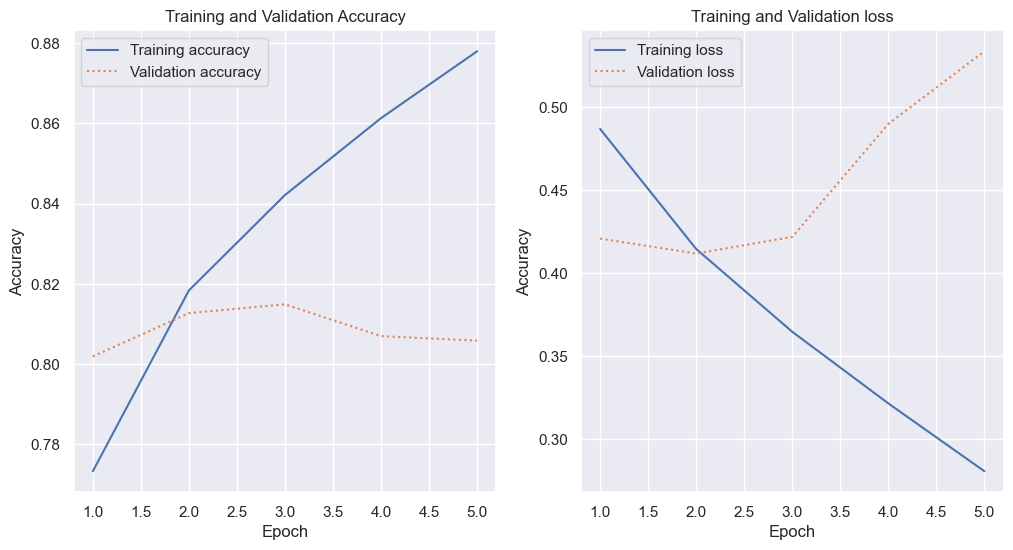

CPU times: total: 13min 49s
Wall time: 30min 51s


In [23]:
%%time
experiment_name = "Keras simple"
mlflow.set_experiment(experiment_name)
with mlflow.start_run(run_name="Keras Glove"):
    
    batch_size = 128
    
    pipeline = Pipeline([
        ('clean_text', SpacyTextCleaner(lemmatize=True)),
    ])
    
    df_sample_clean = pipeline.transform(df_sample['text'])
    words = [word for sentence in df_sample_clean for word in sentence]
    nb_words = len(set(words))
    X, _ = prepare_keras_data(df_sample_clean, nb_words, max_len)
    X_train, X_valid, X_test, y_train, y_valid, y_test = train_valid_test_split(X, df_sample['target']) 
    
    
    model = Sequential()
    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix]))
    model.add(Dropout(0.2))
    model.add(Conv1D(200, 4, activation='relu')) 
    model.add(MaxPooling1D(pool_size=4))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(16, activation="relu"))
    model.add(Dense(16, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=2)
    
    hist = model.fit(
        X_train, 
        y_train, 
        epochs=10, 
        batch_size=batch_size, 
        validation_data=(X_valid, y_valid), 
        callbacks=[early_stopping], 
        verbose=1
    )

    
    input_example = X_valid[:5]
    output_example = model.predict(input_example)
    signature = infer_signature(input_example, output_example)
   
    scores = model.evaluate(X_test, y_test, verbose=0)
    print("Accuracy on test data: %.2f%%" % (scores[1] * 100))
    
    mlflow.log_metrics({
    "test_accuracy_score": scores[1] * 100,
#     "test_precision_score": precision_test_set,
#     "test_recall_score": recall_test_set,
#     "test_f1_score": f1_test_set,
#     "test_auc": auc_score_test_set,
    })
    mlflow.keras.log_model(
    model,
    artifact_path="Keras Glove",
    registered_model_name="Keras Glove",
    signature = signature
)
plot_hist(hist)

### Keras simple avec Word2Vec

#### Word2vec

In [25]:
gc.collect()

24217

In [15]:
fasttext.util.download_model('en', if_exists='ignore')  
ft_model = fasttext.load_model('cc.en.300.bin')
fasttext.util.reduce_model(ft_model, 100)
print(ft_model.get_dimension())

KeyboardInterrupt: 

In [ ]:
%%time
vocab_size, embed_dim, embedding_matrix = create_embedding(ft_model)
experiment_name = "Keras simple"
mlflow.set_experiment(experiment_name)
with mlflow.start_run(run_name="Keras Word2vec"):
    
    batch_size = 128
    
    pipeline = Pipeline([
        ('clean_text', SpacyTextCleaner(lemmatize=True)),
    ])
    
    df_sample_clean = pipeline.transform(df_sample['text'])
    words = [word for sentence in df_sample_clean for word in sentence]
    nb_words = len(set(words))
    X, _ = prepare_keras_data(df_sample_clean, nb_words, max_len)
    X_train, X_valid, X_test, y_train, y_valid, y_test = train_valid_test_split(X, df_sample['target']) 
    
    
    model = Sequential()
    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix]))
    model.add(Conv1D(200, 4, activation='relu')) 
    model.add(MaxPooling1D(pool_size=4))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(16, activation="relu"))
    model.add(Dense(16, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=2)
    
    hist = model.fit(
        X_train, 
        y_train, 
        epochs=10, 
        batch_size=batch_size, 
        validation_data=(X_valid, y_valid), 
        callbacks=[early_stopping], 
        verbose=1
    )

    
    input_example = X_valid[:5]
    output_example = model.predict(input_example)
    signature = infer_signature(input_example, output_example)
   
    scores = model.evaluate(X_test, y_test, verbose=0)
    print("Accuracy on test data: %.2f%%" % (scores[1] * 100))
    
    mlflow.log_metrics({
    "test_accuracy_score": scores[1] * 100,
#     "test_precision_score": precision_test_set,
#     "test_recall_score": recall_test_set,
#     "test_f1_score": f1_test_set,
#     "test_auc": auc_score_test_set,
    })
    mlflow.keras.log_model(
    model,
    artifact_path="Keras Word2vec",
    registered_model_name="Keras Word2vec",
    signature = signature
)
plot_hist(hist)

### Modèle Keras avec Embedding pré entrainé Glove + couche LSTM

In [37]:
vocab_size, embedding_dim, embedding_matrix = create_embedding(glove_model)
experiment_name = "Keras LSTM"
mlflow.set_experiment(experiment_name)
with mlflow.start_run(run_name="LSTM-Glove"):
    
    batch_size = 128
    lstm_out = 200
    
    pipeline = Pipeline([
        ('clean_text', SpacyTextCleaner(lemmatize=True)),
    ])
    
    df_sample_clean = pipeline.transform(df_sample['text'])
    words = [word for sentence in df_sample_clean for word in sentence]
    nb_words = len(set(words))
    X, _ = prepare_keras_data(df_sample_clean, nb_words, max_len)
    X_train, X_valid, X_test, y_train, y_valid, y_test = train_valid_test_split(X, df_sample['target']) 
    
    
    model = Sequential()
    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix]))
    model.add(Conv1D(200, 5, activation='relu')) 
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=4))
    model.add(LSTM(lstm_out, recurrent_dropout=0.2))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=2)
    
    hist = model.fit(
        X_train, 
        y_train, 
        epochs=10, 
        batch_size=batch_size, 
        validation_data=(X_valid, y_valid), 
        callbacks=[early_stopping], 
        verbose=1
    )

    
    input_example = X_valid[:5]
    output_example = model.predict(input_example)
    signature = infer_signature(input_example, output_example)
   
    scores = model.evaluate(X_test, y_test, verbose=0)
    print("Accuracy on test data: %.2f%%" % (scores[1] * 100))
    
    mlflow.log_metrics({
    "test_accuracy_score": scores[1] * 100,
#     "test_precision_score": precision_test_set,
#     "test_recall_score": recall_test_set,
#     "test_f1_score": f1_test_set,
#     "test_auc": auc_score_test_set,
    })
    mlflow.keras.log_model(
    model,
    artifact_path="LSTM-Glove",
    registered_model_name="LSTM-Glove",
    signature = signature
)
plot_hist(hist)

2023/07/04 18:33:12 INFO mlflow.tracking.fluent: Experiment with name 'Keras LSTM' does not exist. Creating a new experiment.


ResourceExhaustedError: {{function_node __wrapped__AddV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:AddV2]

In [ ]:
stop

### BERT

In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(list(X_train), truncation=True, padding=True)
val_encodings = tokenizer(list(X_valid), truncation=True, padding=True)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

hist = model.fit(train_encodings, y_train, validation_data=(val_encodings, y_valid), epochs=5)
scores = model.evaluate(test_encodings, y_test, verbose=0)
print("Test accuracy with BERT: %.2f%%" % (scores[1]*100))
plot_hist(hist)

In [ ]:
stop

In [ ]:
%%time
experiment_name = "Keras model"
mlflow.set_experiment(experiment_name)
with mlflow.start_run(run_name="Keras run"):
    
    embed_dim = 64
    batch_size = 128
    
    pipeline = Pipeline([
        ('clean_text', SpacyTextCleaner(lemmatize=True)),
    ])
    
    df_sample_clean = pipeline.transform(df_sample['text'])
    words = [word for sentence in df_sample_clean for word in sentence.split()]
    nb_words = len(set(words))
    X, _ = prepare_keras_data(df_sample_clean, nb_words, max_length_99_percentile)
    X_train, X_valid, X_test, y_train, y_valid, y_test = train_valid_test_split(X, df_sample['target']) 
    
    
    model = Sequential()
    model.add(w2v_embedding_layer)
    model.add(Flatten())
    model.add(Dense(16, activation='relu')) 
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.5)) 
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=3)
    
    hist = model.fit(
        X_train, 
        y_train, 
        epochs=30, 
        batch_size=64, 
        validation_data=(X_valid, y_valid), 
        callbacks=[early_stopping], 
        verbose=1
    )

    
    input_example = X_valid[:5]
    output_example = model.predict(input_example)
    signature = infer_signature(input_example, output_example)
   
    scores = model.evaluate(X_test, y_test, verbose=0)
    print("Accuracy on test data: %.2f%%" % (scores[1] * 100))
    
    mlflow.log_metrics({
    "test_accuracy_score": scores[1] * 100,
#     "test_precision_score": precision_test_set,
#     "test_recall_score": recall_test_set,
#     "test_f1_score": f1_test_set,
#     "test_auc": auc_score_test_set,
    })
    mlflow.keras.log_model(
    model,
    artifact_path="Keras",
    registered_model_name="Keras",
    signature = signature
)
plot_hist(hist)

## Modèle LSTM

In [ ]:
%%time
experiment_name = "LSTM model"
mlflow.set_experiment(experiment_name)
with mlflow.start_run(run_name="LSTM run"):
    
    embed_dim = 32
    lstm_out = 200
    batch_size = 64
    
    pipeline = Pipeline([
        ('clean_text', SpacyTextCleaner(lemmatize=True)),
    ])

    df_sample_clean = pipeline.transform(df_sample['text'])
    X, nb_words = prepare_keras_data(df_sample_clean, nb_words, max_length_99_percentile)
    X_train, X_valid, X_test, y_train, y_valid, y_test = train_valid_test_split(X, df_sample['target'])
    
    model = Sequential()
    model.add(w2v_embedding_layer)
    model.add(LSTM(lstm_out, dropout = 0.2, recurrent_dropout = 0.2))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
    print(model.summary())
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=3)
    
    hist = model.fit(
        X_train, 
        y_train, 
        epochs=20, 
        batch_size=batch_size, 
        validation_data=(X_valid, y_valid), 
        callbacks=[early_stopping], 
        verbose=1
    )
    
    scores = model.evaluate(X_test, y_test, verbose=0, batch_size= batch_size)
    print("Accuracy on test data: %.2f%%" % (scores[1] * 100))
    
plot_hist(hist)

### Exemple BERT

In [ ]:
# Construction via add_pipe with default model
trf = nlp.add_pipe("transformer")

# Construction via add_pipe with custom config
config = {
    "model": {
        "@architectures": "spacy-transformers.TransformerModel.v3",
        "name": "bert-base-uncased",
        "tokenizer_config": {"use_fast": True},
        "transformer_config": {"output_attentions": True},
        "mixed_precision": True,
        "grad_scaler_config": {"init_scale": 32768}
    }
}
trf = nlp.add_pipe("transformer", config=config)

# Construction from class
from spacy_transformers import Transformer
trf = Transformer(nlp.vocab, model)